# Objective: To develop an automated predictive model that accurately estimates the annual medical expenditure of new customers at ACME Insurance Inc. using demographic and health-related attributes such as age, sex, BMI, number of children, smoking status, and region of residence. The model will leverage historical customer data to support data-driven determination of appropriate annual insurance premiums.

In [1]:
import pandas as pd
import numpy as np
import statsmodels
import warnings
warnings.filterwarnings('ignore')

import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pickle

In [2]:
df = pd.read_csv(r"C:\Users\FAUZAN\OneDrive\Desktop\Insurance_premium_prediction\insurance.csv")

In [3]:
df


,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95


# To predict medical expenses using customer demographic and health information, enabling estimation of expenses for new customers based on their details.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


In [6]:
# Let us see more statiscal information of the categorical features 
df.describe(include="O")

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


# Exploratory Analysis and Visualization
Let's explore the data by visualizing the distribution of values in some columns of the dataset, and the relationships between "expenses" and other columns.

In [7]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

# Age:
Age is a numerical variable ranging from 18 to 64. Its distribution can be visualized using a histogram with 47 bins (one for each year) and a box plot to identify spread and outliers.

In [8]:
fig = px.histogram(df, 
                   x='age', 
                   marginal='box', 
                   nbins=47, 
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()

The age distribution is nearly uniform, with approximately 20–30 customers at each age, except for ages 18 and 19, which have more than twice as many customers compared to other ages.

# Body Mass Index (BMI):
The distribution of customers’ BMI can be examined using a histogram and a box plot to understand its spread and identify potential outliers.

In [9]:
fig = px.histogram(df,
                    x='bmi',
                    marginal='box',
                    color_discrete_sequence=['red'],
                    title='Distribustion of BMI (Body Mass Index)')

fig.update_layout(bargap=0.1)
fig.show()

The BMI values approximately follow a Gaussian distribution centered around 30, with a few right-skewed outliers.

# Expenses:
The distribution of annual medical expenses can be visualized to understand overall spending patterns. Additionally, separating the data by smoking status allows comparison of expenses between smokers and non-smokers, highlighting differences relevant to prediction.

In [10]:
fig = px.histogram(df,
                    x='expenses',
                    marginal='box',
                    color='smoker',
                    color_discrete_sequence=['green', 'orange'],
                    title="Annual Medical Expenses")

fig.update_layout(bargap=0.1)
fig.show()

The following observations can be made:

Most customers have annual medical expenses below $10,000, with only a small fraction incurring much higher costs, likely due to serious illnesses, accidents, or genetic conditions. The distribution appears to follow a power-law pattern.

There is a substantial difference in expenses between smokers and non-smokers. The median expense for non-smokers is approximately $7,300, while for smokers it is close to $35,000.

# Expenses and Gender:
The distribution of medical expenses can be visualized by grouping customers by sex to compare expense patterns between males and females.

In [11]:
fig = px.histogram(df,
                    x="expenses",
                    marginal="box",
                    color="sex",
                    color_discrete_sequence=["blue", "purple"],
                    title="Annual Medical Expenses by Sex")

fig.update_layout(bargap=0.1)
fig.show()    

The following observation can be made:

While the median medical expenses for males and females are nearly the same, males show a much higher upper range of expenses, with an upper fence around $42,000 compared to approximately $28,000 for females.

# Distribution of Expenses by Region:
The distribution of medical expenses can be visualized by grouping customers by region (southwest, southeast, northwest, and northeast) to compare regional differences in spending patterns.

In [12]:
fig = px.histogram(df,
                    x="expenses",
                    marginal="box",
                    color="region",
                    color_discrete_sequence=["grey", "orange", "green","violet"],
                    title="Annual Medical Expenses by Region")

fig.update_layout(bargap=0.1)
fig.show()  

The following observations can be made:

Medical expenses vary across regions. The median expenses are approximately $8,798 for the southwest, $9,294 for the southeast, $8,965 for the northwest, and $10,050 for the northeast.

The upper range of expenses also differs by region: about $26,000 for the southwest, $42,000 for the southeast, $42,300 for the northwest, and $34,000 for the northeast.

# Smoker:
The distribution of the smoker variable can be visualized using a histogram to show the count of smokers (“yes”) versus non-smokers (“no”) in the dataset.

In [13]:
px.histogram(df, x="smoker", color="sex", title="Smoker")

The following observations can be made:

About 20% of the customers are smokers.

Smoking appears to be more common among male customers than female customers.

In [14]:
px.histogram(df, x="region", color="smoker", title="Region")

In [15]:
px.histogram(df, x="smoker", color="children", title="Smoker Vs Children")

Having explored individual columns, we can now examine how “expenses”—our target variable—relates to other features in the dataset. This helps identify patterns, correlations, and potential predictors for building a predictive model.

We can visualize relationships with:

Numerical features (e.g., age, BMI, children) using scatter plots or box plots.

Categorical features (e.g., sex, smoker, region) using box plots or violin plots.

This step is crucial for understanding which features have the strongest impact on medical expenses.

# Age and Expenses:

We can visualize the relationship between age and expenses using a scatter plot, where:

Each point represents a customer.

The x-axis shows age, and the y-axis shows expenses.

Points are colored by smoker status to highlight differences between smokers and non-smokers.

In [16]:
fig = px.scatter(df,
                x="age",
                y="expenses",
                color="smoker",
                opacity=0.8,
                hover_data=["sex"],
                width=800,
                height=500,
                title="Age vs Expenses")

fig.update_traces(marker_size=5)
fig.show()      

Observations from the scatter plot:

Medical expenses generally increase with age, but vary widely, so age alone is not a reliable predictor.

Three clusters are visible:

Healthy non-smokers with low expenses.

Mixed group of smokers and non-smokers with moderate expenses.

Smokers with high expenses, likely due to smoking-related health issues.

# BMI and Expenses:

A scatter plot shows BMI (x-axis) vs expenses (y-axis), with points colored by smoker status to highlight differences between smokers and non-smokers.

In [17]:
fig = px.scatter(df,
                x="bmi",
                y="expenses",
                color="smoker",
                hover_data=['sex'],
                opacity=0.8,
                width=800,
                height=500,
                title="BMI Vs Expenses")

fig.update_traces(marker_size=5)
fig.show()  

For non-smokers, BMI has little effect on expenses, but smokers with a BMI over 30 tend to have significantly higher medical expenses.

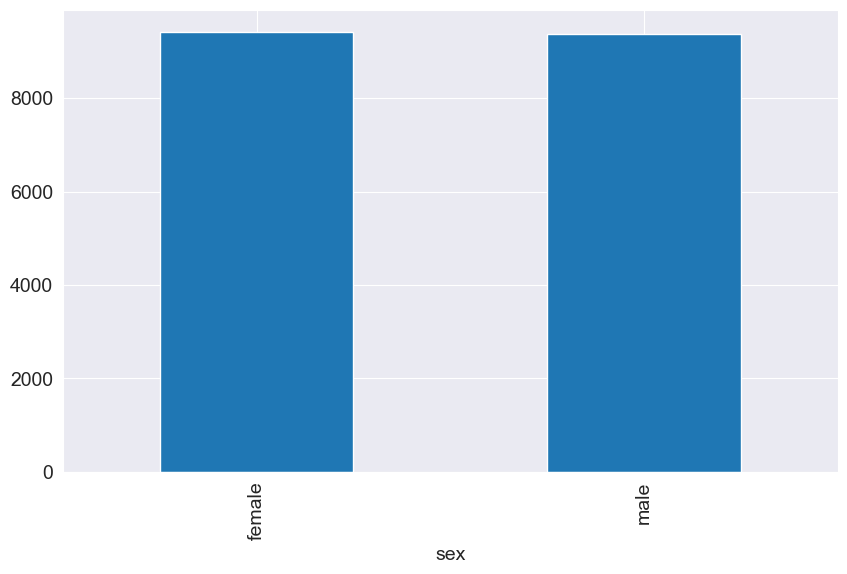

In [18]:
df.groupby("sex")['expenses'].median().plot.bar()
plt.show()

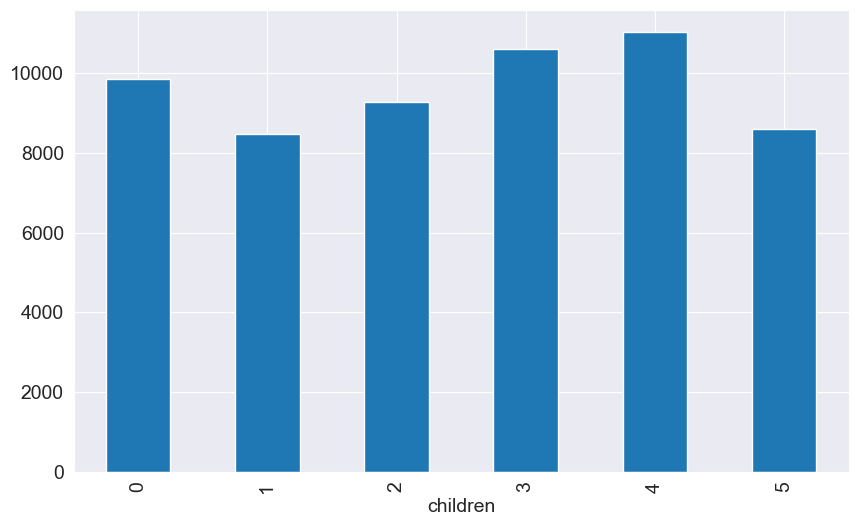

In [19]:
df.groupby("children")['expenses'].median().plot.bar()
plt.show()

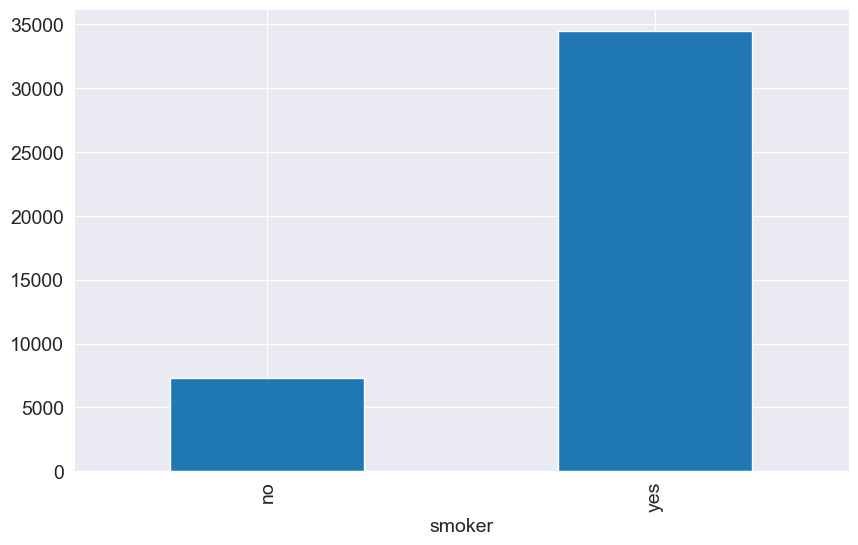

In [20]:
df.groupby("smoker")['expenses'].median().plot.bar()
plt.show()


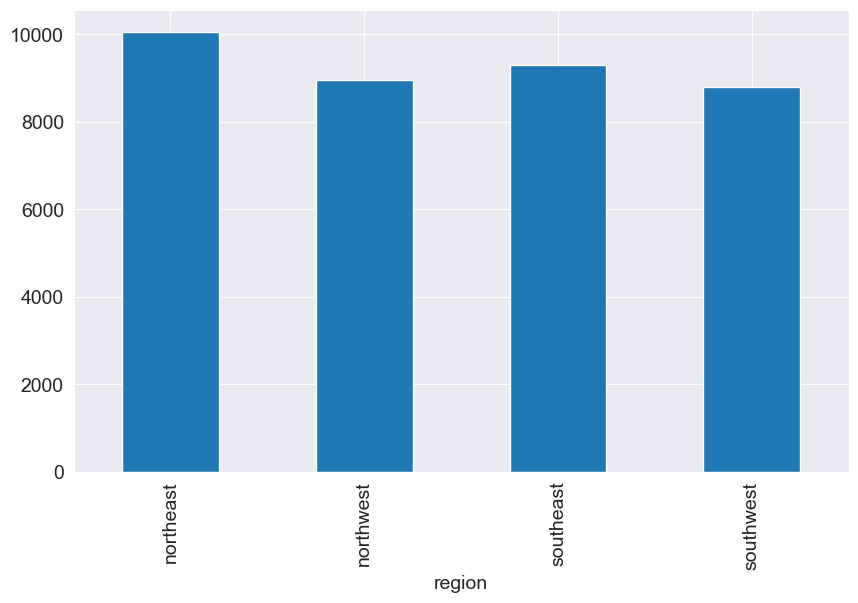

In [21]:
df.groupby("region")['expenses'].median().plot.bar()
plt.show()

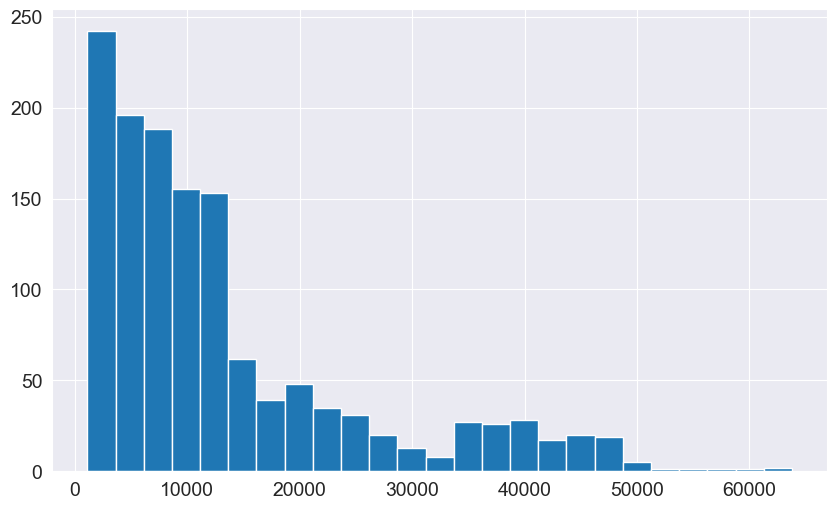

In [22]:
df['expenses'].hist(bins=25)
plt.show()

In [23]:
fig = px.histogram(data_frame=df, x='bmi', y='expenses', width=800, height=500, title='Expenses by BMI')
fig.show()

In [24]:
fig = px.histogram(df, x="bmi", y="expenses", color="sex", marginal="rug", hover_data=df.columns)
fig.show()

In [25]:
fig = px.scatter(df, x="bmi", y="expenses", color='sex', facet_col="children")
fig.update_xaxes(matches=None)
fig.show()

In [26]:
fig = px.pie(data_frame=df, names='sex', values='expenses', width=800, height=500, title='Expenses by Gender')
fig.show()

In [27]:
fig = px.scatter(df, x="bmi", y="expenses", color="sex", width=900, height=500, title="Expenses by BMI & Gender")
fig.show()

In [28]:
fig = px.scatter(df, x="bmi", y="expenses", color="smoker", width=900, height=500, title="Expenses by BMI & Smoker")
fig.show()

In [29]:
fig = px.scatter(df, x="bmi", y="expenses", color="region", width=900, height=500, title="Expenses by BMI & Region")
fig.show()


In [30]:
fig = px.violin(df, y="expenses", x= "sex")
fig.show()

From left plot the insurance charge for male and female is approximatley in same range,it is average around 50k.

In [31]:
fig = px.violin(df, y="expenses", x= "smoker")
fig.show()

In right plot the health expenses for smokers is much wide range compare to non smokers, the average expenses for non smoker is approximately 5000 bucks. For smoker the minimum health expenses is itself 5000 bucks.

In [32]:
fig = px.scatter(df, x="bmi", y="expenses", color="sex", marginal_y="violin",
           marginal_x="box", trendline="ols", template="simple_white")
fig.show()

In [33]:
fig = px.scatter(df, x="bmi", y="expenses", color="smoker", marginal_y="violin",
           marginal_x="box", trendline="ols", template="simple_white")
fig.show()

In [34]:
fig = px.scatter(df, x="bmi", y="expenses", color="region", marginal_y="violin",
           marginal_x="box", trendline="ols", template="simple_white")
fig.show()


In [35]:
fig = px.box(df, x="children", y="expenses", color="smoker", notched=True, title= "Expenses by Children & Smoker")
fig.show()

# Correlation

In [36]:
df_numeric = df.select_dtypes(include='number')
df_numeric.corr()


,age,bmi,children,expenses
age,1.000000,0.109341,0.042469,0.299008
bmi,0.109341,1.000000,0.012645,0.198576
children,0.042469,0.012645,1.000000,0.067998
expenses,0.299008,0.198576,0.067998,1.000000


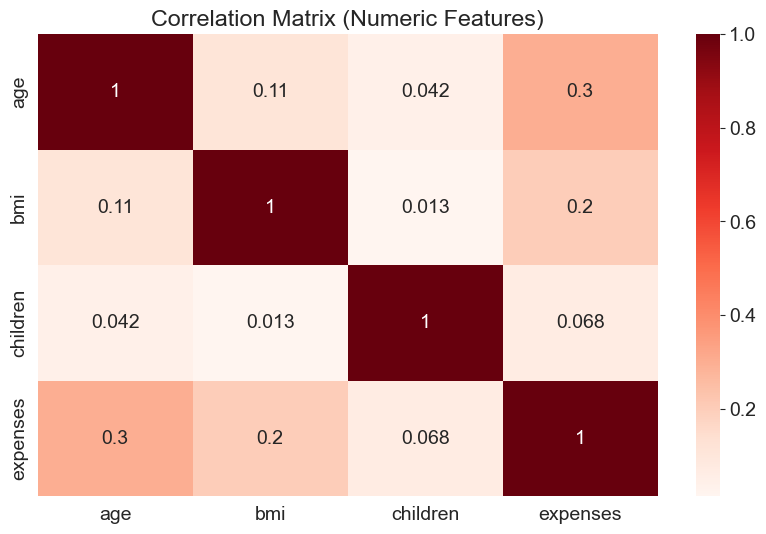

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns only
df_numeric = df.select_dtypes(include='number')

# Plot correlation heatmap
sns.heatmap(df_numeric.corr(), cmap='Reds', annot=True)
plt.title('Correlation Matrix (Numeric Features)')
plt.show()


# Correlation vs Causation:

A high correlation does not imply a cause-effect relationship. Features can be correlated for many reasons, including indirect or coincidental relationships, and correlations may change if the underlying relationship changes or the sample is small.

From our analysis, some features (e.g., age) are more closely related to expenses than others (e.g., BMI). Correlation can be quantified using the correlation coefficient via Pandas’ .corr() method.

In [38]:
df.expenses.corr(df.age)

np.float64(0.29900819228508274)

In [39]:
df.expenses.corr(df.bmi)

np.float64(0.19857625501893203)

To compute the correlation for categorical columns, they must first be converted into numeric columns.

In [40]:
smoker_values = {'no': 0, 'yes': 1}
smoker_numeric = df.smoker.map(smoker_values)
df.expenses.corr(smoker_numeric)

np.float64(0.7872514298985526)

# Interpreting Correlation Coefficients:

Strength: Values close to ±1 indicate a strong linear relationship; 0 means no linear relationship.

Direction: Positive values mean both variables increase together; negative values mean one increases as the other decreases.

Magnitude: Values between 0 and ±1 show a weaker relationship, with points less tightly aligned on a line.

Correlation coefficients can be calculated for numeric columns using Pandas’ .corr() method.

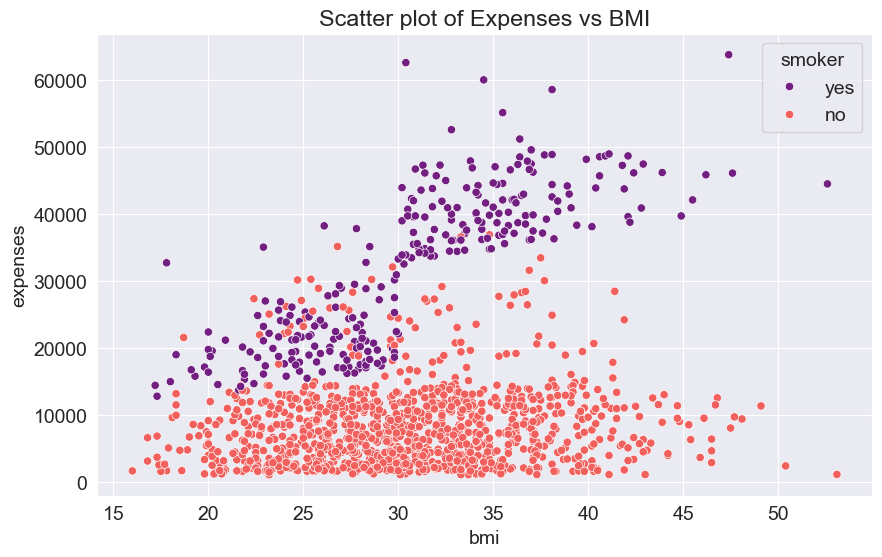

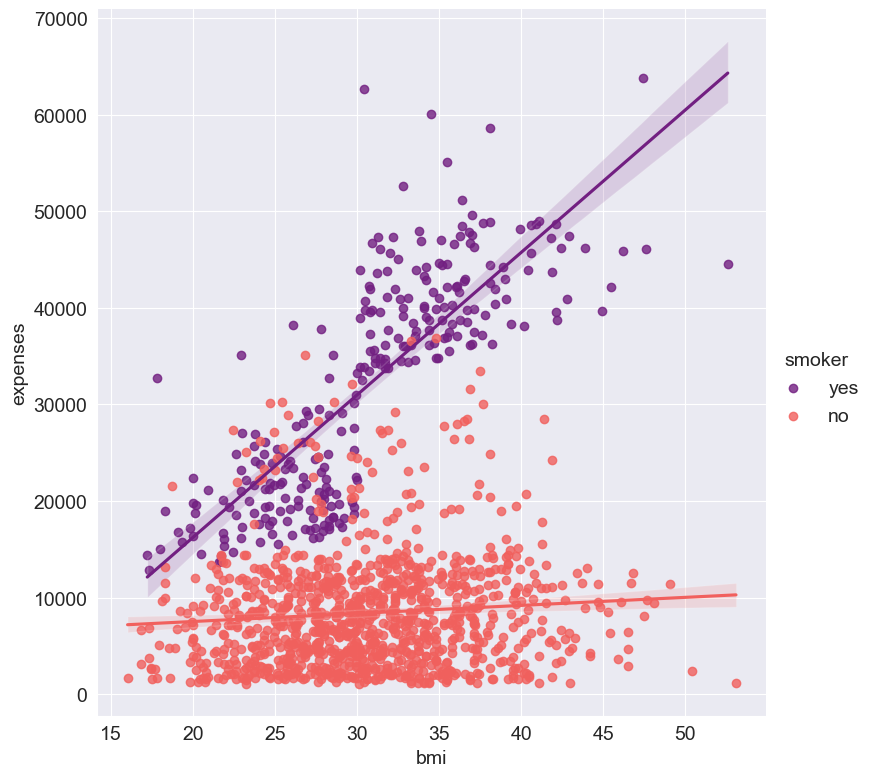

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='bmi', y='expenses', data=df, hue='smoker', palette='magma')
ax.set_title('Scatter plot of Expenses vs BMI')

# Regression plot with hue
sns.lmplot(
    x="bmi", 
    y="expenses", 
    hue="smoker", 
    data=df, 
    palette='magma', 
    height=8  # use 'height' instead of 'size'
)


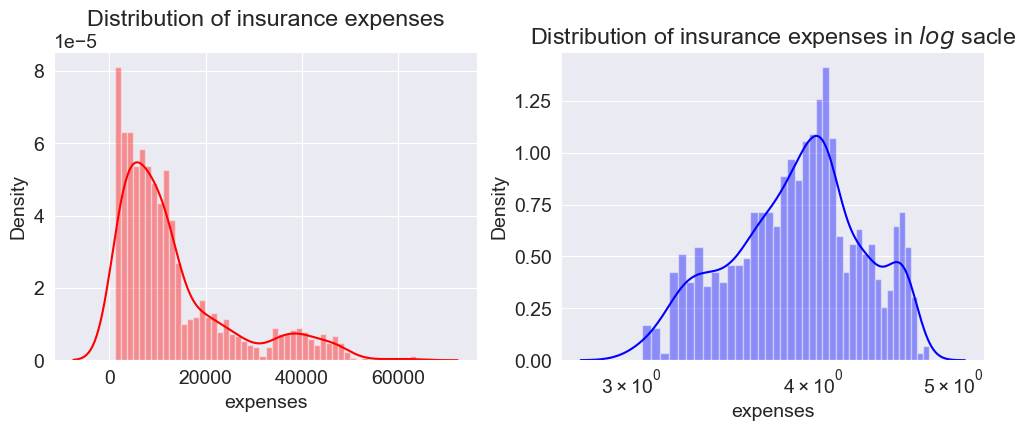

In [42]:
f= plt.figure(figsize=(12,4))

ax=f.add_subplot(121)
sns.distplot(df['expenses'],bins=50,color='r',ax=ax)
ax.set_title('Distribution of insurance expenses')

ax=f.add_subplot(122)
sns.distplot(np.log10(df['expenses']),bins=40,color='b',ax=ax)
ax.set_title('Distribution of insurance expenses in $log$ sacle')
ax.set_xscale('log');

The left plot shows that expenses range from $1,120 to $63,500 and are right-skewed. By applying a natural log transformation to expenses (right plot), the distribution becomes approximately normal. For further analysis, we will use log-transformed charges as the target variable.

In [43]:
X = df.drop(['expenses'], axis=1)
y = df['expenses']

In [44]:
X.to_csv('clean_data.csv')

# Standard Scaler:

Standardization is a common preprocessing step for many machine learning algorithms, which perform better when features are roughly normally distributed with similar scales.

It transforms the data so that each feature has:

Mean = 0

Standard deviation = 1

This makes the data scale-free and improves model performance.

# One-Hot Encoding:

The region column has 4 categories, so we use one-hot encoding to create a separate binary column for each region. This allows machine learning models to use categorical data effectively.

In [45]:
# Creating new variables for numerical attributes/columns
numeric_features = ['age', 'bmi', 'children']
# Making pipeline for scaling down numerical features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Creating new variables for categorical attributes/columns
categorical_features = ['sex', 'smoker','region']
# MAking pipeling for Encoding categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Creating new variable for these numerical & categorical features pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
print(X_train.shape, y_test.shape)

(1070, 6) (268,)


# Loss/Cost Function:

We measure model performance using Root Mean Squared Error (RMSE):

Compute the difference between actual and predicted values (residuals).

Square the residuals to remove negatives.

Take the average of these squared differences.

Take the square root of the result to get RMSE.

RMSE gives a single number representing how close predictions are to actual values.

# Linear Regression

In [48]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

linear_reg = Pipeline(steps=[('preprocessor', preprocessor), ('linear_regressor', LinearRegression())])

linear_reg.fit(X_train, y_train)
y_pred = linear_reg.predict(X_test)

# MSE
linear_reg_mse = mean_squared_error(y_test, y_pred)

# RMSE (manual calculation)
linear_reg_rmse = np.sqrt(linear_reg_mse)

# R2 score
linear_reg_r2_score = r2_score(y_test, y_pred)

print("Mean Squared Error:", linear_reg_mse)
print("Root Mean Squared Error:", linear_reg_rmse)
print("R2 Score:", linear_reg_r2_score)


Mean Squared Error: 33600065.355077825
Root Mean Squared Error: 5796.556335884076
R2 Score: 0.7835726930039906


In [49]:
score = []
for i in range(1000):
    X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=i)
    clf = Pipeline(steps=[('preprocessor', preprocessor),('regressor', LinearRegression())])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score.append(r2_score(y_test, y_pred))

In [50]:
np.argmax(score)

np.int64(367)

In [51]:
score[np.argmax(score)]

0.8330631587714108

# Decision Tree

In [52]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

# Decision Tree pipeline
decision_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('decision_tree_regressor', DecisionTreeRegressor(
        max_depth=4, min_samples_split=4, random_state=42))
])

# Fit model
decision_tree.fit(X_train, y_train)

# Predict
y_pred1 = decision_tree.predict(X_test)

# Evaluation Metrics
decision_tree_mse = mean_squared_error(y_test, y_pred1)       # use y_pred1
decision_tree_rmse = np.sqrt(decision_tree_mse)               # manual RMSE
decision_tree_r2_score = r2_score(y_test, y_pred1)

print("Mean Squared Error (Decision Tree):", decision_tree_mse)
print("Root Mean Squared Error (Decision Tree):", decision_tree_rmse)
print("R2 Score (Decision Tree):", decision_tree_r2_score)


Mean Squared Error (Decision Tree): 23690709.32592509
Root Mean Squared Error (Decision Tree): 4867.310276315358
R2 Score (Decision Tree): 0.8387892658296556


# Random Forest

In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Random Forest pipeline
random_forest_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('random_forest_regressor', RandomForestRegressor(
        n_estimators=100, max_depth=4, random_state=42))
])

# Fit model
random_forest_reg.fit(X_train, y_train)

# Predict
y_pred2 = random_forest_reg.predict(X_test)

# Evaluation Metrics
random_forest_mse = mean_squared_error(y_test, y_pred2)
random_forest_rmse = np.sqrt(random_forest_mse)   # manual RMSE
random_forest_r2_score = r2_score(y_test, y_pred2)

print("Mean Squared Error (Random Forest):", random_forest_mse)
print("Root Mean Squared Error (Random Forest):", random_forest_rmse)
print("R2 Score (Random Forest):", random_forest_r2_score)


Mean Squared Error (Random Forest): 22326826.034284692
Root Mean Squared Error (Random Forest): 4725.127091865857
R2 Score (Random Forest): 0.8480702300989443


In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Random Forest pipeline
random_forest_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('random_forest_regressor', RandomForestRegressor(
        n_estimators=30, max_depth=4, min_samples_split=5, random_state=42))
])

# Fit model
random_forest_reg.fit(X_train, y_train)

# Predict
y_pred2 = random_forest_reg.predict(X_test)

# Evaluation Metrics
random_forest_mse = mean_squared_error(y_test, y_pred2)
random_forest_rmse = np.sqrt(random_forest_mse)  # manual RMSE
random_forest_r2_score = r2_score(y_test, y_pred2)

print("Mean Squared Error (Random Forest):", random_forest_mse)
print("Root Mean Squared Error (Random Forest):", random_forest_rmse)
print("R2 Score (Random Forest):", random_forest_r2_score)


Mean Squared Error (Random Forest): 22147774.06754165
Root Mean Squared Error (Random Forest): 4706.142163974825
R2 Score (Random Forest): 0.8492886443986674


# Gradient Boosting

In [55]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Gradient Boosting pipeline
gradient_boosting_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('gradient_boosting', GradientBoostingRegressor())
])

# Fit model
gradient_boosting_reg.fit(X_train, y_train)

# Predict
y_pred3 = gradient_boosting_reg.predict(X_test)

# Evaluation Metrics
gradient_boosting_mse = mean_squared_error(y_test, y_pred3)
gradient_boosting_rmse = np.sqrt(gradient_boosting_mse)  # manual RMSE
gradient_boosting_r2_score = r2_score(y_test, y_pred3)

print("Mean Squared Error (Gradient Boosting):", gradient_boosting_mse)
print("Root Mean Squared Error (Gradient Boosting):", gradient_boosting_rmse)
print("R2 Score (Gradient Boosting):", gradient_boosting_r2_score)


Mean Squared Error (Gradient Boosting): 22681199.26771303
Root Mean Squared Error (Gradient Boosting): 4762.478269526595
R2 Score (Gradient Boosting): 0.8456587881980138


In [56]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Gradient Boosting pipeline
gradient_boosting_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('gradient_boosting', GradientBoostingRegressor(
        n_estimators=41, max_depth=3, min_samples_split=4, random_state=42))
])

# Fit the model
gradient_boosting_reg.fit(X_train, y_train)

# Predict
y_pred3 = gradient_boosting_reg.predict(X_test)

# Evaluation Metrics
gradient_boosting_mse = mean_squared_error(y_test, y_pred3)
gradient_boosting_rmse = np.sqrt(gradient_boosting_mse)  # manual RMSE
gradient_boosting_r2_score = r2_score(y_test, y_pred3)

print("Mean Squared Error (Gradient Boosting):", gradient_boosting_mse)
print("Root Mean Squared Error (Gradient Boosting):", gradient_boosting_rmse)
print("R2 Score (Gradient Boosting):", gradient_boosting_r2_score)


Mean Squared Error (Gradient Boosting): 21644204.04957958
Root Mean Squared Error (Gradient Boosting): 4652.333183423086
R2 Score (Gradient Boosting): 0.8527153418092427


# KNN

In [57]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# KNN pipeline
knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor(n_neighbors=10))
])

# Fit the model
knn.fit(X_train, y_train)

# Predict
y_pred4 = knn.predict(X_test)

# Evaluation Metrics
knn_mse = mean_squared_error(y_test, y_pred4)
knn_rmse = np.sqrt(knn_mse)  # manual RMSE
knn_r2_score = r2_score(y_test, y_pred4)

print("Mean Squared Error (KNN):", knn_mse)
print("Root Mean Squared Error (KNN):", knn_rmse)
print("R2 Score (KNN):", knn_r2_score)


Mean Squared Error (KNN): 33407923.373968963
Root Mean Squared Error (KNN): 5779.958769227421
R2 Score (KNN): 0.7726654875491433


# XGBoost

In [58]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# XGBoost pipeline
xgb_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', xgb.XGBRegressor())
])

# Fit the model
xgb_reg.fit(X_train, y_train)

# Predict
y_pred5 = xgb_reg.predict(X_test)

# Evaluation Metrics
xgb_reg_mse = mean_squared_error(y_test, y_pred5)
xgb_reg_rmse = np.sqrt(xgb_reg_mse)  # manual RMSE
xgb_reg_r2_score = r2_score(y_test, y_pred5)

print("Mean Squared Error (XGBoost):", xgb_reg_mse)
print("Root Mean Squared Error (XGBoost):", xgb_reg_rmse)
print("R2 Score (XGBoost):", xgb_reg_r2_score)


Mean Squared Error (XGBoost): 33220338.149608932
Root Mean Squared Error (XGBoost): 5763.708714847492
R2 Score (XGBoost): 0.7739419690306621


In [59]:
models = pd.DataFrame({
    'Model' : ['Linear Regression', 'Decision Tree', 'Random Forest',
               'Gradient Boosting', 'KNN', 'XGBoost'],
    'RMSE' : [linear_reg_rmse, decision_tree_rmse, random_forest_rmse,
            gradient_boosting_rmse, knn_rmse, xgb_reg_rmse],
    'r2_score' : [linear_reg_r2_score, decision_tree_r2_score, random_forest_r2_score, 
    gradient_boosting_r2_score, knn_r2_score, xgb_reg_r2_score]
})

models.sort_values(by='RMSE', ascending=True)

,Model,RMSE,r2_score
3,Gradient Boosting,4652.333183,0.852715
2,Random Forest,4706.142164,0.849289
1,Decision Tree,4867.310276,0.838789
5,XGBoost,5763.708715,0.773942
4,KNN,5779.958769,0.772665
0,Linear Regression,5796.556336,0.783573


From the table, Gradient Boosting has the lowest RMSE (4,652.33) and the highest R² (0.8527), indicating it outperforms the other models.

In [60]:
pickle.dump(gradient_boosting_reg, open('gradient_boosting_regressor_model.pkl', 'wb'))